# Watson Assistant Metrics Notebook (VIA)

This notebook performs analytics on the user log records of Watson Assistant (including Voice Interaction). The logs are extracted, transformed, and loaded into a DB2 database and CSV files. A variety of key business metrics are calculated and displayed in the notebook. Using Watson Studio to build a Dashboard are recommended for further data exploration and dashboard visualizations. 

<br> <div> 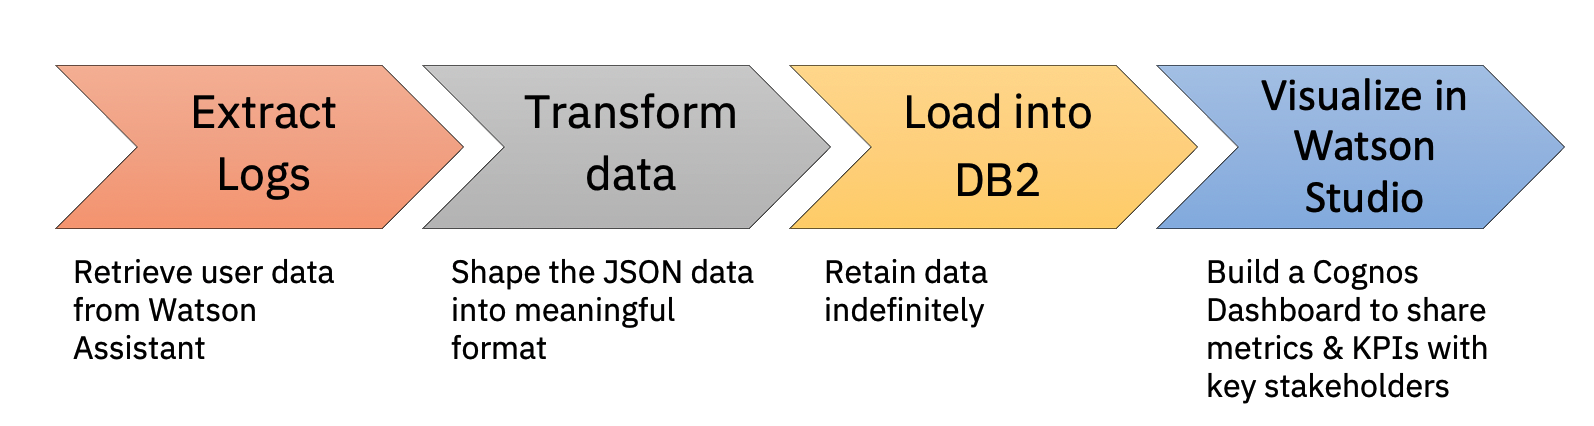 </div>          

### Table of Contents
* [1. Configuration and Log Collection](#config) - This section will extract and transform the user log data from Watson Assistant.
* [2. Key Performance Metrics](#performance-metrics) - Key metrics including containment rate, active users, and top intents will be calculated. 
* [3. Export Logs](#export-logs) The transformed log data will be saved to a DB2 database and CSV files.

## Housekeeping <a class="anchor" id="housekeeping"></a>
This section will import libraries and dependencies for this notebook. 
 
> **Action Required:** Update the `project_id` and `project_access_token` in order to access your data assets. Instructions can be found here: https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html

In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='812799c9-fbb7-457b-8878-f422b5cda86d', project_access_token='p-e436c5e727078ba93c448546e6cf55cc4bd0e7c8')
pc = project.project_context


In [2]:
!curl -O https://raw.githubusercontent.com/cognitive-catalyst/WA-Testing-Tool/master/log_analytics/getAllLogs.py
!curl -O https://raw.githubusercontent.com/cognitive-catalyst/WA-Testing-Tool/master/log_analytics/extractConversations.py

%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter("ignore")

!pip install ibm-watson
!pip install --user --upgrade "pandas==1.0.3";

import json
import pandas as pd
import getAllLogs
import extractConversations
import seaborn as sn
import ibm_db
import ibm_db_dbi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6318  100  6318    0     0  23486      0 --:--:-- --:--:-- --:--:-- 23486
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11230  100 11230    0     0  71075      0 --:--:-- --:--:-- --:--:-- 71075
     |████████████████████████████████| 378kB 11.2MB/s eta 0:00:01
     |████████████████████████████████| 204kB 34.5MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/71/9a/0a/9b3ca8eca69bc5362eb04709a750b30055a9d27818fd0c9494
  Stored in directory: /home/dsxuser/.cache/pip/wheels/6a/42/50/f96888116b329578304f9dda4693cef6f3e76e18272d22cb6c
Successfully built ibm-watson ibm-cloud-sdk-core
     |████████████████████████████████| 10.0MB 7.9MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement nump

In [3]:
# Custom functions to re-use code throughout notebook
def turn_dict_to_df(df,col_names):
    df = pd.DataFrame.from_dict(df)
    df.reset_index(level=0, inplace=True)
    df.columns = col_names
    return df

## 1. Configuration and log collection <a class="anchor" id="config"></a>
This section will configure your DB2 connection, log query parameters, and will extract the logs from your Watson Assistant instance.

> **Action Required:** Update each of the variables marked with 'XXXXXXXX'.  The comments in the cells guide you in the configuration.

In [4]:
# Define the customer name. This prefix will be used for saving CSV & JSON files.
custName = 'VIA'

# Set True or False if you want data to write to DB2 table
connectDB2 = True

# Set the start date for the log fetch. If you are using the DB2 connection in Section 1.1, this will be defined automatically.
log_fetch_start = '2020-05-15'

### 1.1 Configure & Establish DB2 connection
This section will define the values for your DB2 database, establish the connection, check for the last loaded date.

> **Action Required:** You will first need to provision your DB2 instance and establish the table schemas. Follow these instructions. Then, update the values below marked 'XXXXXXXX'. 

In [5]:
# Enter the values for you database connection. This can be found in DB2's Service Credentials from the tooling. 
dsn_database = "BLUDB"            # e.g. "MORTGAGE"
dsn_uid      = "bluadmin"            # e.g. "dash104434"
dsn_pwd      = "MTRhZDFhZjM2OWFj"            # e.g. "7dBZ3jWt9xN6$o0JiX!m"
dsn_hostname = "dashdb-txnha-flex-yp-dal09-37.services.dal.bluemix.net"            # e.g. "Use the same IP as Web Console"
dsn_port     = "50000"               # e.g. "50000" 
dsn_protocol = "TCPIP"               # i.e. "TCPIP"
dsn_driver   = "IBM DB2 ODBC DRIVER" # Don't change

In [6]:
# Establish database connection
if connectDB2 == True:
    dsn = ("DRIVER={{IBM DB2 ODBC DRIVER}};" "DATABASE={0};" "HOSTNAME={1};" "PORT={2};" "PROTOCOL=TCPIP;" "UID={3};" "PWD={4};").format(dsn_database, dsn_hostname, dsn_port, dsn_uid, dsn_pwd)
    options = { ibm_db.SQL_ATTR_AUTOCOMMIT:  ibm_db.SQL_AUTOCOMMIT_ON }
    conn = ibm_db.connect(dsn, "", "",options)
    #Added options for auto commit
    
    # Retrieve the date for the previous DB2 run. If there is none defined, use 2020-04-15. This variable log_fetch_start is used for filtering WA logs.
    select_sql = 'SELECT * FROM WATSON.WA_LAST_RUN_LOG'
    select_stmt = ibm_db.exec_immediate(conn, select_sql)
    prev_run = ibm_db.fetch_both(select_stmt)
    first_run = True
    log_fetch_start = '2020-04-15'
    if prev_run != False:
        first_run = False
        l_conversation_id = prev_run.get('CONVERSATION_ID')
        l_request_timestamp = prev_run.get('REQUEST_TIMESTAMP')
        l_response_timestamp = prev_run.get('RESPONSE_TIMESTAMP')
        l_prev_run = prev_run.get('LASTRUN_TIMESTAMP')
        log_fetch_start = str(l_response_timestamp.date())
print('log_fetch_start:',log_fetch_start)

log_fetch_start: 2020-04-15


### 1.2 Retrieve logs from the Watson Assistant instance
This section will retrieve the user logs from the Assistant `/logs` API.

> **Action Required:** Update the fields below marked 'XXXXXXXX' based on the credentials of your Assistant. 
Solutions using an Assistant layer (v2 API) should set `workspace_id=None` and provide `assistant_id`. Otherwise, define workspace and comment out assistant_id.




In [7]:
# Extract logs from your assistant. Complete this information.
iam_apikey = 'Qbt29YHx9EJ3esV6p0U0EA_wycHAEkYdoqTfX-e59571' #VIA
url = "https://api.us-east.assistant.watson.cloud.ibm.com" # Set the URL to the region 
assistant_id = '8378ee71-ab6d-4a8e-890e-7232557b411a' # VIA
workspace_id = None

# If not using assistant_id, comment out the 2nd line below. 
log_filter="language::en,response_timestamp>=" + log_fetch_start \
+",request.context.system.assistant_id::" + assistant_id

#Change the number of logs retrieved, default settings will return 100,000 logs (200 pages of 500)
page_size_limit=500
page_num_limit=200

version="2018-09-20" # Watson Assistant API version

rawLogsJson = getAllLogs.getLogs(iam_apikey, url, workspace_id, log_filter, page_size_limit, page_num_limit, version)
rawLogsPath= custName + "_logs.json"

# getAllLogs.writeLogs(rawLogsJson, rawLogsPath) # Saves the logs locally
project.save_data(file_name = rawLogsPath,data = json.dumps(rawLogsJson),overwrite=True); # Saves the logs in Studio/COS
print('\nSaved log data to {}'.format(rawLogsPath))

Fetched 1 log pages
Fetched 2 log pages
Fetched 3 log pages
Fetched 4 log pages

Saved log data to VIA_logs.json


### 1.3 Load logs from JSON file (Defunct)
If you have previously saved the JSON file, you can uncomment this section to load the logs. Otherwise, comment this section out and continue.

In [8]:
# #If you have previously stored your logs on the file system, you can reload them here by uncommenting these lines
# rawLogsPath= custName+"_logs.json"
# rawLogsJson = extractConversations.readLogs(rawLogsPath)

### 1.4 Format logs
Now that the logs have been retrieved, this section will transform the data out of JSON format and into a Pandas dataframe. 

> **Optional:** If you wish to add any custom fields (such as a context variable), add it the first line `customFieldNames` below. Otherwise, run this cell as-is.

In [9]:
# Optionally provide a comma-separated list of custom fields you want to extract, in addition to the default fields
customFieldNames = 'response.context.preferredContact,response.context.contactSubmitted'

# Unique conversation identifier across all records. This is default. For a multi-skill assistant you will need to provide your own key.
primaryLogKey = "response.context.conversation_id"
conversationKey='conversation_id' # Name of the correlating key as it appears in the data frame columns (remove 'response.context.')

# These custom fields are added to the list. They are used for extracting metrics in the notebook. Do not change these.
customFieldNames = customFieldNames + ",response.context.vgwSIPFromURI,response.context.vgwSessionID,request.context.vgwSMSFailureReason,\
request.context.vgwSMSUserPhoneNumber,response.output.vgwAction.parameters.transferTarget,response.context.language,\
response.context.metadata.user_id,response.output.generic"

allLogsDF = extractConversations.extractConversationData(rawLogsJson, primaryLogKey, customFieldNames)
conversationsGroup = allLogsDF.groupby(conversationKey,as_index=False)

# Splits the response_timestamp into month, day, and year fields that can be used for easier data filtering/visualizations 
allLogsDF["full_date"] = pd.to_datetime(allLogsDF["response_timestamp"])
allLogsDF['month'] = allLogsDF['full_date'].dt.month
allLogsDF['day'] = allLogsDF['full_date'].dt.day
allLogsDF['year'] = allLogsDF['full_date'].dt.year

print("Total log events:",len(allLogsDF))
allLogsDF.head()

Total log events: 1603


,conversation_id,dialog_turn_counter,request_timestamp,response_timestamp,input.text,output.text,nodes_visited,branch_exited_reason,preferredContact,contactSubmitted,...,prev_nodes_visited,conversation_start,message_start,message_end,dialog_turn_number,conversation_length,full_date,month,day,year
0,019fe2f3-6940-4b9a-92cf-018d2d903b23,1.0,2020-05-19 12:56:07.416000+00:00,2020-05-19 12:56:07.426000+00:00,,Hello! What can I help you with today?,"(Welcome,)",completed,,,...,,2020-05-19 12:56:07.416000+00:00,00:00:00,00:00:00,1,191,2020-05-19 12:56:07.426000+00:00,5,19,2020
1,019fe2f3-6940-4b9a-92cf-018d2d903b23,2.0,2020-05-19 12:56:14.897000+00:00,2020-05-19 12:56:15.002000+00:00,Economic Opportunity,,"(root,)",,,,...,"(Welcome,)",2020-05-19 12:56:07.416000+00:00,00:00:00.010000,00:00:07.481000,2,191,2020-05-19 12:56:15.002000+00:00,5,19,2020
2,019fe2f3-6940-4b9a-92cf-018d2d903b23,3.0,2020-05-19 12:56:27.726000+00:00,2020-05-19 12:56:27.762000+00:00,hi,Hello! What can I help you with today?,"(node_1_1588696147469,)",completed,,,...,"(root,)",2020-05-19 12:56:07.416000+00:00,00:00:07.586000,00:00:20.310000,3,191,2020-05-19 12:56:27.762000+00:00,5,19,2020
3,019fe2f3-6940-4b9a-92cf-018d2d903b23,4.0,2020-05-19 12:56:34.424000+00:00,2020-05-19 12:56:34.478000+00:00,howdy,Hello! What can I help you with today?,"(node_1_1588696147469,)",completed,,,...,"(node_1_1588696147469,)",2020-05-19 12:56:07.416000+00:00,00:00:20.346000,00:00:27.008000,4,191,2020-05-19 12:56:34.478000+00:00,5,19,2020
4,019fe2f3-6940-4b9a-92cf-018d2d903b23,5.0,2020-05-19 12:56:40.119000+00:00,2020-05-19 12:56:40.172000+00:00,hey,Hello! What can I help you with today?,"(node_1_1588696147469,)",completed,,,...,"(node_1_1588696147469,)",2020-05-19 12:56:07.416000+00:00,00:00:27.062000,00:00:32.703000,5,191,2020-05-19 12:56:40.172000+00:00,5,19,2020


In [10]:
# Print the column names
# allLogsDF.columns

# 2. Key Performance Metrics <a class="anchor" id="performance-metrics"></a>
The notebook will calculate various performance metrics including `coverage` and `containment`. Standard volume metrics will also be provided.

* [2.1 Core Metrics](#core-metrics) - These are conversational metrics that apply to both chat and voice solutions.
* [2.2 Voice Interaction Metrics](#voice-metrics) - Additional measurements for voice solutions including phone calls, call transfers, unique caller IDs, etc.
* [2.3 Custom Metrics](#custom-metrics) - Other ad-hoc analysis. Requires knowledge of Python.

## 2.1 Core Metrics <a class="anchor" id="core-metrics"></a>
These metrics apply to all Watson Assistant solutions. For voice solutions, additional metrics are in the next section.
* [2.1.1 Abandonment at Greeting](#abandonment)
* [2.1.2 Coverage Metric](#coverage-metric)
* [2.1.3 Search Skill Responses](#search-skill)
* [2.1.4 Escalation Requests](#escalation-metric)
* [2.1.5 Active Users](#active-users)
* [2.1.6 Top Intents & Average Confidence Scores](#top-intents-scores)
* [2.1.7 Top Entities](#top-entities)
* [2.1.8 Optional: Bilingual Assistants](#bilingual-assistants)

In [11]:
# dict{} that we will send to CSV for use in Watson Studio Cognos Dashboard
metrics_dict = {}

# These should match the count in the Watson Assistant Analytics tooling.
totalConvs = len(allLogsDF[conversationKey].unique())
print("Total messages:     ", len(allLogsDF))
print("Total conversations:", totalConvs)

Total messages:      1603
Total conversations: 185


### 2.1.1 Abandonment at Greeting <a class="anchor" id="abandonment"></a>

The logs include non-user messages such as welcome messages and system messages from a Voice Interaction solution. By filtering out these messages, it will reveal how many conversations abandoned before the first user utterance.

In [12]:
# This removes blank inputs and vgwHangUp tags in log events
filteredLogsDF = allLogsDF[allLogsDF['input.text'] != ""]
filteredLogsDF = filteredLogsDF[filteredLogsDF['input.text'] != 'vgwHangUp'] 
filteredLogsDF = filteredLogsDF[filteredLogsDF['input.text'] != 'vgwPostResponseTimeout'] 

filteredMessages = len(filteredLogsDF)
filteredConvs = len(filteredLogsDF[conversationKey].unique())
abandonedAtGreeting = (totalConvs - filteredConvs)
metrics_dict['abandonedAtGreeting'] = [abandonedAtGreeting] # Put into metrics dict

print("Abandoned conversations (no user input):", abandonedAtGreeting)

Abandoned conversations (no user input): 36


### 2.1.2 Coverage Metric <a class="anchor" id="coverage-metric"></a>
Coverage is the measurement of the portion of total user messages that your assistant is attempting to respond to. For example, any messages that respond with "Sorry I didn't understand" from the anything_else node is considered uncovered.

> **Action Required:** Define the node ids in `anything_else_nodes` list that represent any responses for uncovered messages. This can be found by exporting the Skill from the Assistant tooling, and searching the JSON for the relevant `dialog_node`. 

In [13]:
# Define the node_id for anything_else and other uncovered nodes
anything_else_nodes = ['node_7_1588955144231'] 

# coveredDF = allLogsDF
allLogsDF.rename(columns={'input.text': 'input_text'}, inplace=True)
coverage = []

for row in allLogsDF.itertuples():
    appended = False 
    nodes = row.nodes_visited
    for node in nodes:
        if node in anything_else_nodes:
            coverage.append('uncovered') # Mark as uncovered if message hit node in anything_else_nodes list
            appended = True
            break
    if (row.input_text == '' or row.input_text == 'vgwHangUp' or row.input_text == 'vgwPostResponseTimeout') and not appended:
        coverage.append('system_message') # Mark greetings and voicegateway actions as system_messages
        appended = True
    if not appended:
        coverage.append('covered') # else, everything else is covered

allLogsDF['coverage'] = coverage
allLogsDF.rename(columns={'input_text': 'input.text'}, inplace=True)
coveredDF = allLogsDF[allLogsDF['coverage'] == 'covered']
uncoveredDF = allLogsDF[allLogsDF['coverage'] == 'uncovered']

print('Covered messages:   ', len(coveredDF))
print('Uncovered messages: ', len(allLogsDF[allLogsDF['coverage'] == 'uncovered']))
print('System messages:    ', len(allLogsDF[allLogsDF['coverage'] == 'system_message']))
print('\nCoverage metric:    ','{:.0%}'.format(len(coveredDF) / filteredMessages))

# coveredMsgs[['input_text','output.text','coverage']].tail(10)

metrics_dict['coverage'] = [len(coveredDF) / filteredMessages] # Put into metrics dict

Covered messages:    1353
Uncovered messages:  102
System messages:     148

Coverage metric:     93%


In [14]:
# uncoveredDF[['input.text','output.text']].head(10)

### 2.1.2 Search Skill Responses <a class="anchor" id="search-skill"></a>
Watson Assistant has multiple response types including `text`, `option`, `image`, `pause`, or `search skill`. Each of these types are marked within `output.generic.response_type` inside the log data. This cell will calculate the number of Search Skill responses.

In [15]:
# Run this cell
response_type = []

for row in allLogsDF['output.generic']:
    search_skill = False
    for response in row: # each output can have multiple responses
        if response['response_type'] == 'search_skill':
            response_type.append('search_skill')
            search_skill = True
            break
                
    if not search_skill: # if the response was not a search skill, append other to the list
        response_type.append('other')
        
allLogsDF['response_type'] = response_type # Add in response_type column to allLogsDF
searchSkillDF = allLogsDF[allLogsDF['response_type'] == 'search_skill'] # Set new DF 
print('Total Search Skill responses:',len(searchSkillDF))
print('Percentage of total messages: {:.0%}'.format(len(searchSkillDF) / len(allLogsDF) ))

searchSkillDF[['input.text','response_type']].head().reset_index(drop=True) # Print the list of user inputs that caused search skill

Total Search Skill responses: 172
Percentage of total messages: 11%


,input.text,response_type
0,horseplay,search_skill
1,mp3 player,search_skill
2,ramps,search_skill
3,why is my bus late?,search_skill
4,Fail,search_skill


In [16]:
# Saves to CSV
project.save_data(file_name = custName + "_search-skill-inputs.csv",data = searchSkillDF.to_csv(index=False),overwrite=True); # This saves in COS. Comment out if running locally

### 2.1.3 Escalation Requests <a class="anchor" id="escalation-metric"></a>

Escalation refers to any time a user is prompted to contact a live person (e.g. 1-800 number). If the assistant has an integration with a live handoff service (e.g. ZenDesk), this is considered escalation. For Voice Interaction solutions, we calculate `call containment` in the next section by counting the number of actual call transfers in the logs.

> **Action Required:** Define the node id in `escalation_node` for a node that represents any responses to an escalation request (e.g. `#General-Agent-Escalation`). This can be found by exporting the Skill from the Assistant tooling, and searching the JSON for the relevant dialog_node.
 

In [17]:
# Define the escalation node
escalation_node = "node_6_1591127516200" 
node_visits_escalated = allLogsDF[[escalation_node in x for x in allLogsDF['nodes_visited']]]

escalationMetric = len(node_visits_escalated)/filteredMessages
metrics_dict['escalation'] = [escalationMetric] # Put into metrics dict
print("Total visits to escalation node:",len(node_visits_escalated))
print("Percent of total messages escalated:",'{:.0%}'.format(escalationMetric))

Total visits to escalation node: 6
Percent of total messages escalated: 0%


### 2.1.4 Active Users <a class="anchor" id="active-users"></a>
How many unique users used the assistant?

In [18]:
uniqueUsers = allLogsDF["metadata.user_id"].nunique()
metrics_dict['uniqueUsers'] = [uniqueUsers] # inserts into metrics dict
print('Total unique users: {}'.format(uniqueUsers))

Total unique users: 31


### 2.1.5 Top Intents & Average Confidence Scores <a class="anchor" id="top-intents-scores"></a>

In [19]:
# Using pandas aggregators to count how often each intent is selected and its average confidence
intentsDF = filteredLogsDF.groupby('intent',as_index=False).agg({
   'input.text': ['count'], 
   'intent_confidence': ['mean']
})

intentsDF.columns=["intent","count","confidence"] #Flatten the column headers for ease of use

intentsDF = intentsDF[intentsDF['intent'] !=''] # Remove blanks, usually VGW tags + greetings
intentsDF = intentsDF.sort_values('count',ascending=False)
intentsDF = intentsDF.reset_index(drop=True)
intentsDF.head(5) # If you want specific number shown, edit inside head(). If you want to show all, remove head() 

,intent,count,confidence
0,fare,257,0.937545
1,code_of_conduct,244,0.860500
2,next-bus,114,0.937476
3,location,88,0.861030
4,General_Connect_to_Agent,51,0.868052


In [20]:
#ax = sns.barplot(x="count", y="intent", data=intentsDF.head(),orient='h',palette="Blues_d").set_title('Top Intents')

### 2.1.6 Top Entities (Defunct) <a class="anchor" id="top-entities"></a>

In [21]:
entityDF = allLogsDF[allLogsDF["entities"] != ""]
#intentsDF = intentsDF[intentsDF['intent'] !=''] # Remove blanks, usually VGW tags + greetings
entityDF["entities"].iloc[0]

({'entity': 'solicting',
  'location': [0, 5],
  'value': 'howdy',
  'confidence': 0.8670065999031067},)

### 2.1.7 Optional: Bilingual Assistants <a class="anchor" id="bilingual-assistants"></a>
For assistants that use a single skill for two different languages. The skill may set a context variable (e.g. `$language=="english"`) and then respond accordingly based on this variable. This cell will count the unique conversation_ids that have a given context variable.

> **Optional:** Define the `languageVar` that your skill uses to identify the language used to respond to the user.

In [22]:
languageVar = 'language' # define the context variable that you retrieved above in customFields

languageDF = allLogsDF.groupby([languageVar])["conversation_id"].nunique()
languageDF = turn_dict_to_df(languageDF, ['Context Var', 'Count'])
languageDF = languageDF[languageDF['Context Var'] != '']
languageDF

,Context Var,Count


## 2.2 Voice Interaction Metrics <a class="anchor" id="voice-metrics"></a>
These metrics are for Voice Agent solutions. We start with volume metrics. 
If your solution is chat only, [skip to the next section.](#export-to-csv)

* [2.2.1 Call Containment Rate](#containment-rate)
* [2.2.2 Unique Callers](#unique-callers)
* [2.2.3 SMS Sent](#sms-sent)

In [23]:
uniqueCallers = allLogsDF['vgwSIPFromURI'].unique()
uniqueCalls = allLogsDF['vgwSessionID'].unique()

print("Total phone calls:", len(uniqueCalls)) # It will print '1' if there are no calls found in the logs
print("Total unique callers:", len(uniqueCallers))
print("Average messages per call:", int(len(allLogsDF) / len(uniqueCalls)))

Total phone calls: 1
Total unique callers: 1
Average messages per call: 1603


In [24]:
# Filters out blank inputs and vgwHangUp tags in log events
filteredLogsDF = allLogsDF[allLogsDF['input.text'] != ""]
filteredLogsDF = filteredLogsDF[filteredLogsDF['input.text'] != 'vgwHangUp'] 
filteredLogsDF = filteredLogsDF[filteredLogsDF['input.text'] != 'vgwPostResponseTimeout'] 

### 2.2.1 Call Containment Rate <a class="anchor" id="containment-rate"></a>
How many call transfers did the voice solution perform?

In [25]:
transfersDF = allLogsDF.groupby(["output.vgwAction.parameters.transferTarget"])["vgwSessionID"].count()
transfersDF = turn_dict_to_df(transfersDF, ['TransferTo', 'Count'])
transfersDF = transfersDF[transfersDF['TransferTo'] != '']

print('Call transfer count:', transfersDF['Count'].sum()) 
containmentRate = 1 - transfersDF['Count'].sum() / len(uniqueCalls)
print('Call containment rate:', '{:.0%}'.format(containmentRate))
metrics_dict['callTransfers'] = [transfersDF['Count'].sum()] # Put into metrics dict
metrics_dict['containment'] = [containmentRate] # Put into metrics dict
transfersDF.sort_values('Count',ascending=False)

Call transfer count: 0
Call containment rate: 100%


,TransferTo,Count


### 2.2.2 Unique Callers <a class="anchor" id="unique-callers"></a>
How many unique caller IDs dialed into the voice solution?

In [26]:
callsDF = allLogsDF.groupby(['vgwSIPFromURI'])['vgwSessionID'].nunique()
callsDF = pd.DataFrame.from_dict(callsDF)
callsDF.reset_index(level=0, inplace=True)
callsDF.columns = ['Caller ID', 'Call Count']
print('Total unique caller IDs:', len(callsDF))
callsDF.head().sort_values('Call Count',ascending=False)
metrics_dict['callerIDs'] = [len(callsDF)] # Put into metrics dict

Total unique caller IDs: 1


### 2.2.3 SMS Sent <a class="anchor" id="sms-sent"></a>
How many SMS were sent by the assistant? A text message can be sent to the caller and can be initiated from within the Watson Assistant JSON editor. This will count the number of SMS sent.

In [27]:
smsDF = allLogsDF[allLogsDF['vgwSMSUserPhoneNumber'] != '']
metrics_dict['sms'] = [len(smsDF)] # Put into metrics dict
print('Total SMS sent to callers: {}'.format(len(smsDF)))

Total SMS sent to callers: 0


## 2.3 Custom Metrics <a class="anchor" id="custom-metrics"></a>
This section is optional and can be used to create custom metrics. It will require the basic knowledge of Python and Pandas. Two examples of custom metrics included below can be modified, or additional metrics can be added here. [Jump to section 2.4](#export-logs) if you do not wish to build custom metrics.

* [2.3.1 Context Variable Count](#context-variable-count)
* [2.3.2 Response Mentions](#response-mentions)

### 2.3.1 Context Variable Count <a class="anchor" id="context-variable-count"></a>
Some use cases require the use of context variables in order to track user inputs. For one customer, the assistant asks a series of questions in order to screen the patient. 

> **Optional:** If you wish to count the number of context variables used across unique conversation IDs, define `contextVar` below.

In [28]:
contextVar = 'preferredContact' # define the context variable that you retrieved above in customFields

contextDF = allLogsDF.groupby([contextVar])["conversation_id"].nunique()
contextDF = turn_dict_to_df(contextDF, ['Context Var', 'Count'])
contextDF = contextDF[contextDF['Context Var'] != '']
contextDF

,Context Var,Count
1,both,1
2,email,2
3,phone,5


In [29]:
contextVar = 'contactSubmitted' # define the context variable that you retrieved above in customFields

contextDF = allLogsDF.groupby([contextVar])["conversation_id"].nunique()
contextDF = turn_dict_to_df(contextDF, ['Context Var', 'Count'])
contextDF = contextDF[contextDF['Context Var'] != '']
contextDF

,Context Var,Count
0,True,2


In [30]:
# project.save_data(file_name = custName + "_ScreeningCount.csv",data = customVarDF.to_csv(index=False),overwrite=True) # This saves in COS. Comment out if running locally

### 2.3.2 Response Mentions <a class="anchor" id="response-mentions"></a>
A specific customer wanted to identify all mentions of `311` in the responses to users. You can modify this or comment it out.

In [31]:
helpDF = allLogsDF[(allLogsDF['output.text'].str.contains('311')) | (allLogsDF['output.text'].str.contains('3-1-1'))] 
print('Total 3-1-1 response mentions:', len(helpDF))

Total 3-1-1 response mentions: 0


# 3. Export Logs  <a class="anchor" id="export-logs"></a>
The transformed log data inside the Pandas dataframe will be saved to CSV files and DB2 on Cloud database. These logs can be used for further data exploration and for creating visualizations in Cognos Dashboard in Watson Studio.

* [3.1 Saving CSV files to Cloud Object Storage](#export-to-csv)  CSV files will be saved to the project's Data Assets and Cloud Object Storage.
* [3.2 Loading into DB2 on Cloud database](#export-to-db2) The data will be saved to a table on your DB2 instance. 

## 3.1 Saving CSV files to Cloud Object Storage <a class="anchor" id="export-to-csv"></a>
The data will be saved into a CSV file in Cloud Object Storage, accessible via your project's assets folder in Watson Studio. There will be three distinct CSV files saved:
* `_logs.csv` will contain all of the data within the allLogs dataframe
* `_KeyMetrics.csv` will contain the calculated metrics such as coverage, escalation, containment rate, etc.
* `_uncovered_msgs.csv` will contain the selection of uncovered messages. This file can be used for making improvements to intent training and dialog responses.


### 3.1.1 Save all logs to CSV

In [32]:
# allLogsDF.to_csv(custName+'_logs.csv',index=False) # This saves if running notebook locally. Comment out for Studio. 
print('Saving all logs to {}'.format(custName+ "_logs.csv"))
project.save_data(file_name = custName + "_logs.csv",data = allLogsDF.to_csv(index=False),overwrite=True); # This saves in COS. Comment out if running locally

Saving all logs to VIA_logs.csv


### 3.1.2 Save KPIs to CSV

In [33]:
metricsDF = pd.DataFrame(metrics_dict)
# metricsDF.to_csv(custName + "_KeyMetrics.csv",index=False) # This saves if running notebook locally. Comment out for Studio. 
project.save_data(file_name = custName + "_KeyMetrics.csv",data = metricsDF.to_csv(index=False),overwrite=True); # This saves in COS. Comment out if running locally
print('Saving key metrics to {}'.format(custName+ "_KeyMetrics.csv"))
metricsDF

Saving key metrics to VIA_KeyMetrics.csv


,abandonedAtGreeting,coverage,escalation,uniqueUsers,callTransfers,containment,callerIDs,sms
0,36,0.929897,0.004124,31,0,1.0,1,0


### 3.1.3 Save uncovered messages to CSV
Improve Coverage by analyzing these uncovered messages. This might require adding training data to Intents or customizing STT models.

In [34]:
print('\nSaved', len(uncoveredDF), 'messages to:', custName + "_uncovered_msgs.csv")
# uncoveredDF.to_csv(custName + "_uncovered_msgs.csv",index=False, header=['Utterance','Response','Intent','Confidence'])

project.save_data(file_name = custName + "_uncovered_msgs.csv",data = uncoveredDF.to_csv(index=False),overwrite=True); # This saves in COS. Comment out if running locally


Saved 102 messages to: VIA_uncovered_msgs.csv


## 3.2 Loading into DB2 on Cloud database <a class="anchor" id="export-to-db2"></a>
The transformed log data will be inserted into a table within an instance of DB2 on Cloud. Requires configuration in section 1.1.

In [35]:
# Prepare to create Logs
columns = 'BRANCH_EXITED_REASON,CONVERSATION_ID,DIALOG_TURN_COUNTER,ENTITIES,INPUT_TEXT,INTENT,INTENT_CONFIDENCE,NODES_VISITED,OUTPUT_TEXT,REQUEST_TIMESTAMP,RESPONSE_TIMESTAMP,LANGUAGE,PREV_NODES_VISITED,MONTH,DAY,YEAR,CALLER_ID,VGW_SESSION_ID,SMS_NUMBER,CALL_TRANSFER,USER_ID,COVERAGE'
insertSQL = 'Insert into WATSON.WA_FULL_LOGS(' + columns + ') values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)'
stmt = ibm_db.prepare(conn, insertSQL)
checkSQL = 'Select CONVERSATION_ID,RESPONSE_TIMESTAMP from WATSON.WA_FULL_LOGS where CONVERSATION_ID = ? and RESPONSE_TIMESTAMP = ?'
checkStmt = ibm_db.prepare(conn, checkSQL)
insertSQL

'Insert into WATSON.WA_FULL_LOGS(BRANCH_EXITED_REASON,CONVERSATION_ID,DIALOG_TURN_COUNTER,ENTITIES,INPUT_TEXT,INTENT,INTENT_CONFIDENCE,NODES_VISITED,OUTPUT_TEXT,REQUEST_TIMESTAMP,RESPONSE_TIMESTAMP,LANGUAGE,PREV_NODES_VISITED,MONTH,DAY,YEAR,CALLER_ID,VGW_SESSION_ID,SMS_NUMBER,CALL_TRANSFER,USER_ID,COVERAGE) values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)'

In [36]:
LOG_EVENTS_COUNTER = 0
# Insert the rows from the dataframe into the DB2 table.
for n in range(len(allLogsDF)) :
    # check whether this record exists conversation id, response time stamp
    ibm_db.bind_param(checkStmt,1,allLogsDF.at[n,'conversation_id'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
    ibm_db.bind_param(checkStmt, 2,allLogsDF.at[n,'response_timestamp'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_TYPE_TIMESTAMP)
    #select_stmt = ibm_db.exec_immediate(conn, select_sql)
    select_result = ibm_db.execute(checkStmt)
    row_exists = ibm_db.fetch_both(checkStmt)
    if row_exists == False :
        #Row does not exists, hence insert into the All logs table
        LOG_EVENTS_COUNTER = LOG_EVENTS_COUNTER + 1
        #print('Inserting conversation id: ' + allLogsDF.at[n,'conversation_id'])
        
        ibm_db.bind_param(stmt,1,allLogsDF.at[n,'branch_exited_reason'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt,2,allLogsDF.at[n,'conversation_id'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt,3,allLogsDF.at[n,'dialog_turn_counter'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_DECIMAL)
        ibm_db.bind_param(stmt,4,str(allLogsDF.at[n,'entities'][:1020]), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt,5,str(allLogsDF.at[n,'input.text'][:1020]), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt,6,str(allLogsDF.at[n,'intent'][:1020]), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt,7,allLogsDF.at[n,'intent_confidence'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_DECIMAL)
        ibm_db.bind_param(stmt, 8,str(allLogsDF.at[n,'nodes_visited'][:1020]), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt, 9,str(allLogsDF.at[n,'output.text'][:1020]), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt, 10,allLogsDF.at[n,'request_timestamp'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_TYPE_TIMESTAMP)
        ibm_db.bind_param(stmt, 11,allLogsDF.at[n,'response_timestamp'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_TYPE_TIMESTAMP)

        ibm_db.bind_param(stmt, 12,str(allLogsDF.at[n,'language'][:1020]), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt, 13,str(allLogsDF.at[n,'prev_nodes_visited'][:1020]), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
         
        ibm_db.bind_param(stmt, 14,str(allLogsDF.at[n,'month']), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_INTEGER)
        ibm_db.bind_param(stmt, 15,str(allLogsDF.at[n,'day']), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_INTEGER)
        ibm_db.bind_param(stmt, 16,str(allLogsDF.at[n,'year']), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_INTEGER)

        ibm_db.bind_param(stmt, 17,str(allLogsDF.at[n,'vgwSIPFromURI']), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt, 18,str(allLogsDF.at[n,'vgwSessionID']), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt, 19,str(allLogsDF.at[n,'vgwSMSUserPhoneNumber']), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt, 20,str(allLogsDF.at[n,'output.vgwAction.parameters.transferTarget']), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
        ibm_db.bind_param(stmt, 21,str(allLogsDF.at[n,'metadata.user_id']), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)       
        ibm_db.bind_param(stmt, 22,str(allLogsDF.at[n,'coverage']), ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR) 
        
        ibm_db.execute(stmt)
#ibm_db.commit(conn)
#ibm_db.close(conn)
print('Total log events saved to database:', LOG_EVENTS_COUNTER)

Total log events saved to database: 1603


### Update the current run details (WA_LAST_RUN_LOG)

In [37]:
# Store Current run details
del_tracking = 'Delete from WATSON.WA_LAST_RUN_LOG'
insert_tracking = 'Insert into WATSON.WA_LAST_RUN_LOG (conversation_id, request_timestamp, response_timestamp, lastrun_timestamp) Values (?,?,?,?) '
trans_stmt = ibm_db.prepare(conn, insert_tracking)
insert_tracking

'Insert into WATSON.WA_LAST_RUN_LOG (conversation_id, request_timestamp, response_timestamp, lastrun_timestamp) Values (?,?,?,?) '

In [38]:
#Delete previous entry
ibm_db.exec_immediate(conn,del_tracking)

# Get the latest log entry from the dataframe. First let's sort it so tail(1) is the last entry.
allLogsDF.sort_values(by=['response_timestamp'], axis=0, 
                 ascending=True, inplace=True)
allLogsDF = allLogsDF.reset_index(drop=True)
last_row = allLogsDF.tail(1).reset_index(drop=True)
#store the latest row details.
ibm_db.bind_param(trans_stmt,1,last_row.at[0,'conversation_id'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_VARCHAR)
ibm_db.bind_param(trans_stmt,2,last_row.at[0,'request_timestamp'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_TYPE_TIMESTAMP)
ibm_db.bind_param(trans_stmt,3,last_row.at[0,'response_timestamp'], ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_TYPE_TIMESTAMP)
ibm_db.bind_param(trans_stmt,4,pd.Timestamp.now(),ibm_db.SQL_PARAM_INPUT,ibm_db.SQL_TYPE_TIMESTAMP)
ibm_db.execute(trans_stmt)
print(pd.Timestamp.now())
#Commit and close the connection
ibm_db.commit(conn)
ibm_db.close(conn)

2020-06-08 19:00:25.635915


True

### End of Notebook v2.0 (last modified on 6-8-20)